## Objective

To identify users prone to subscribe to cartola `Cartola Pro` using behavior data.
This is a series of notebooks divided into the following sections:
- **01_eda:**
    - Exploratory data analysis of user profile aiming identify propensity to subscribe to cartola
    - Data wrangling to prepare the dataset for modeling
- **02_model:**
    - Assessing different models with hyperparameter tuning to select the best classifier to discriminate `Cartola Pro`
    - Analyzing feature importances to classify users
- **03_app:**
    - Creating flask API to predict the probability of users to subscribe to cartola

In [4]:
import numpy as np
import pandas as pd
import os
import dabl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pickle
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import researchpy as rp

%matplotlib inline

In [5]:
df = pd.read_csv('data/ge_df_users_editorias_02.zip')
target = 'cartola_status'

Number of unique users is the same as the length of the dataset

In [3]:
print('Shape of dataframe', df.shape)
print('Unique users', df['user'].nunique())

Shape of dataframe (50689, 26)
Unique users 50689


In [8]:
def dataprep_user(df, user='user'):
    '''
    Drop user column
    Returns: dataframe without feature 'user' 
    '''
    df = df.drop(user, axis=1)
    return df

df = dataprep_user(df)

Null values in the target column may be interpreted as `Não Cartola`

In [9]:
def dataprep_cartola(df, target):
    '''
    Fill null values of target column with 'Não Cartola'        
    Returns: dataframe target column as categories
    '''
    df[target] = df[target].fillna('Não Cartola')
    df[target] = pd.Categorical(df[target], ordered=True,
                            categories=['Não Cartola', 'Cartola Free', 'Cartola Pro'])
    return df

df = dataprep_cartola(df, target)

The target is very unbalanced, so we should be aware of this during modeling

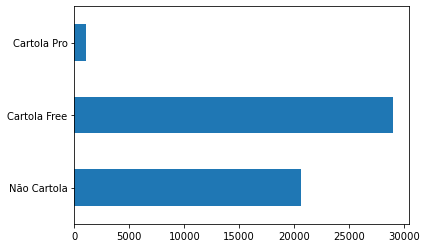

In [7]:
df[target].value_counts().sort_index().plot.barh()
plt.show()

Categorical features such as `sexo`, `device`, and `uf` may present relationship with the target.

I applied chi square statistics and cramer's v to assess the potential relationship.

In [9]:
def stats_chi2(df, index, col, p_val_threshold=0.05, figsize=(10, 2)):
    '''
    Calculate chi-square statistics and relationship between two categorical features
    Returns:     chi-square and cramer's V statistics, and plot contigency table
    '''
    table, results = rp.crosstab(df[index], df[col], prop='col', test='chi-square')
    p_value, cramers_v = results.loc[1, 'results'], results.loc[2, 'results']
    plt.figure(figsize=figsize)
    sns.heatmap(table.iloc[:-1, :-1] , annot=True, cmap='coolwarm')
    plt.show()
    
    if p_value < p_val_threshold:
        print(f'p-value is {p_value}, lower than {p_val_threshold}, so we reject the null hypothesis of independence')
        print(f'The strenght of the relationship between {index} and {col} is {cramers_v}')
        
    else:
        print(f'p-value is greater than {p_val_threshold}, so we fail reject the null hypothesis of independence')
        print(f'Chi-square test did not identified a relationship between {index} and {col}')

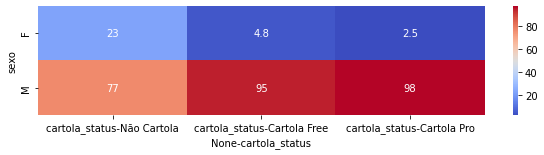

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between sexo and cartola_status is 0.2743


In [10]:
stats_chi2(df, 'sexo', target)

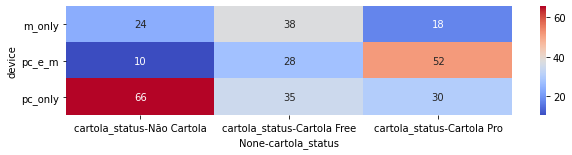

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between device and cartola_status is 0.2323


In [11]:
stats_chi2(df, 'device', target)

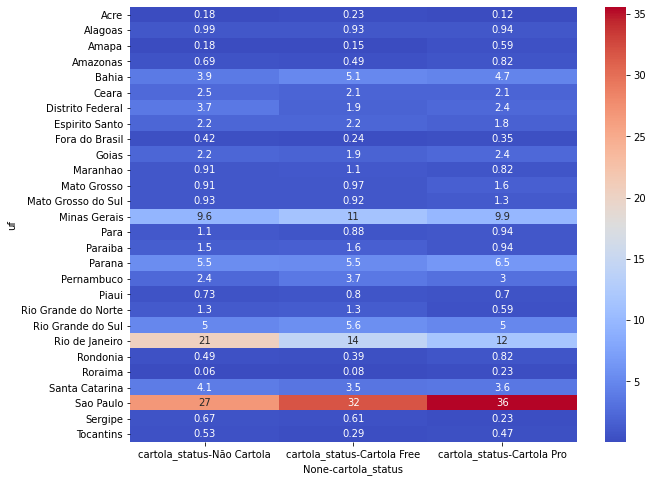

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between uf and cartola_status is 0.0824


In [12]:
stats_chi2(df, 'uf', target, figsize=(10, 8))

As we can see, the three features seem to have relationship with the target.

I will maintain them in the dataset; however, I will apply one hot encoding on `sexo` and `device` and label encoding on `uf`.

In [13]:
def dataprep_dummy(df, dummies=['sexo', 'device']):
    '''
    Create one hot encoding for selected columns
    Returns: dataframe with dummy variables
    '''
    df_dummies = pd.get_dummies(df[dummies])    
    df_ret = pd.concat([df.drop(dummies, axis=1), df_dummies], axis=1)
    return df_ret

df = dataprep_dummy(df)

By plotting `idade`, we can see that there are negative values, as well as very big ages like 236.

I treated `idade` by defining all values below 1 as null and above 100 as 100. Then I set null values as `-999`

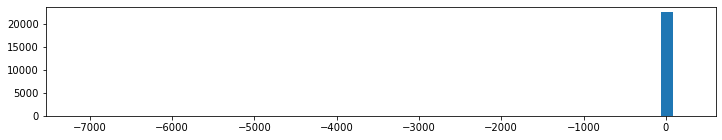

In [14]:
df['idade'].hist(figsize=(12, 2), bins=50, grid=False)

count    22616.000000
mean        29.308719
std         49.140567
min      -7161.000000
25%         22.000000
50%         27.000000
75%         35.000000
max        236.000000
Name: idade, dtype: float64


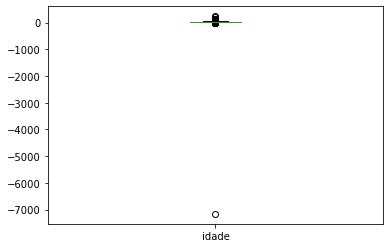

In [15]:
print(df['idade'].describe())
df['idade'].plot.box()

In [16]:
def dataprep_idade(df, idade='idade'):
    '''
    Set age below 1 as null values and age above 100 as 100
    Fill null values with -999
    Returns: dataframe with age transformed
    '''
    df.loc[(df[idade]<=0), idade] = np.nan
    df.loc[(df[idade]>100), idade] = 100
    df[idade] = df[idade].fillna(-999)
    return df

df = dataprep_idade(df)

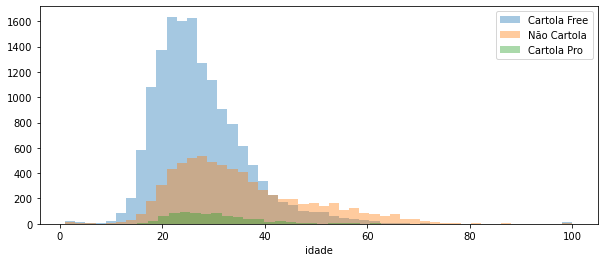

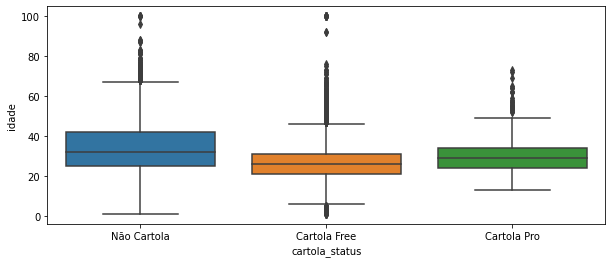

In [18]:
def plot_age(df, target, figsize=(10, 4)):
    '''
    Plot histogram and boxplot of ages above 0 for each target
    '''
    
    plt.figure(figsize=figsize)
    df_idade = df[df['idade'] > 0]
    for unique_target in df_idade[target].unique():
        sns.distplot(df_idade[df_idade[target]==unique_target]['idade'], label=unique_target, kde=False)
        plt.legend()
    plt.show()
    
    plt.figure(figsize=figsize)    
    sns.boxplot(data=df_idade, x=target, y='idade')
    plt.show()
    
plot_age(df, target)

In [19]:
def dataprep_uf(df, col='uf', le=LabelEncoder()):
    '''
    Fill null values with 'outro'
    Label encoder of state
    Returns: dataframe with uf transformed
    '''    
    df[col] = df[col].fillna('outro')
    df[col] = le.fit_transform(df[col])    
    return df

df = dataprep_uf(df)

Now that we have only numerical features, I will analyze the pearson correlation between them

In [20]:
def df_correlations(df):
    '''
    Calculate pearson correlation between features
    Returns: dataframe with the correlation of each different pair of features
    '''    
    lst_cols = []
    cols = df.corr().columns.tolist()

    for col_1 in cols:
        for col_2 in cols:
            lst_cols.append(col_1 + ' + ' + col_2)

    df_corr = pd.Series(df.corr().values.reshape(-1), index=lst_cols)
    df_corr = df_corr[df_corr!=1]
    df_corr.drop_duplicates(inplace=True)
    df_corr = df_corr.sort_values(ascending=False).to_frame(name='pearson_correlation')
    
    return df_corr

df_corr = df_correlations(df)

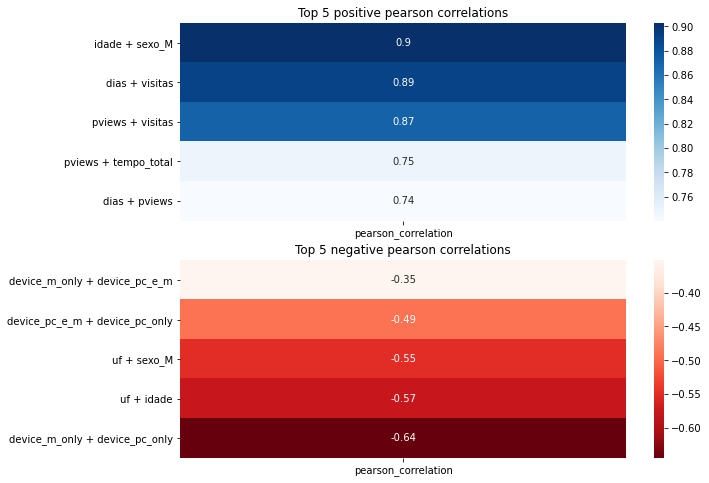

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].set_title('Top 5 positive pearson correlations')
sns.heatmap(df_corr.head(), annot=True, cmap='Blues', ax=ax[0])
ax[1].set_title('Top 5 negative pearson correlations')
sns.heatmap(df_corr.tail(), annot=True, cmap='Reds_r', ax=ax[1])
plt.show()

The features pair `idade + sexo_M` presents the highest correlation; however, they both presented highly number of missing values, which may have contributed to the high correlation.

I will plot the pair `dias + visitas` and `pviews + visitas` for each class.

In [22]:
def plot_scatterplot(df, x, y, target=target, figsize=(10, 4)):
    '''
    Plot scatter plot between two features for each target
    '''
    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x, y=y, hue=target, style=target, alpha=0.3)
    plt.show()    

def plot_lmplot(df, x, y, target=target):
    '''
    Plot scatter plot between two features for each target
    with a fitted linear regression
    '''
    sns.lmplot(data=df, x=x, y=y, col=target, hue=target, height=3)
    plt.show()

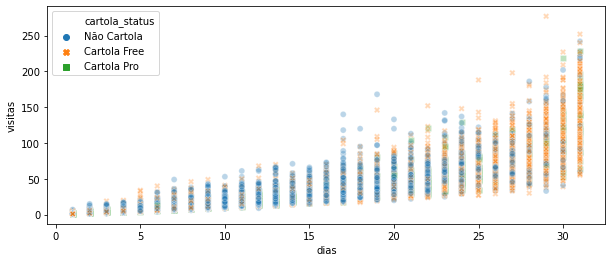

In [23]:
plot_scatterplot(df, 'dias', 'visitas')

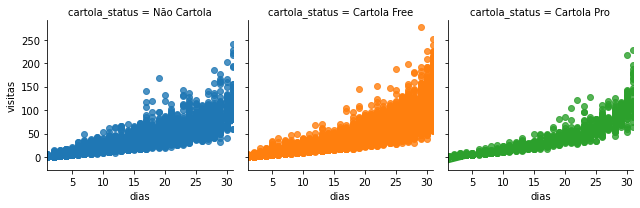

In [24]:
plot_lmplot(df, 'dias', 'visitas')

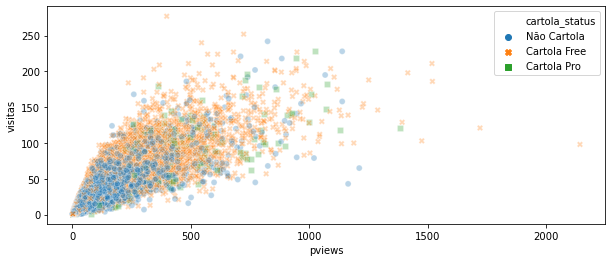

In [25]:
plot_scatterplot(df, 'pviews', 'visitas')

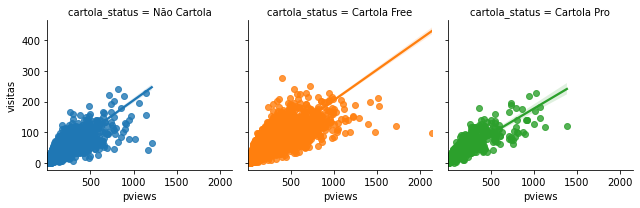

In [26]:
plot_lmplot(df, 'pviews', 'visitas')

We can visualize the correlation with a cluster dendrogram.

This plot should help visualize features that could be grouped.

<Figure size 1152x720 with 0 Axes>

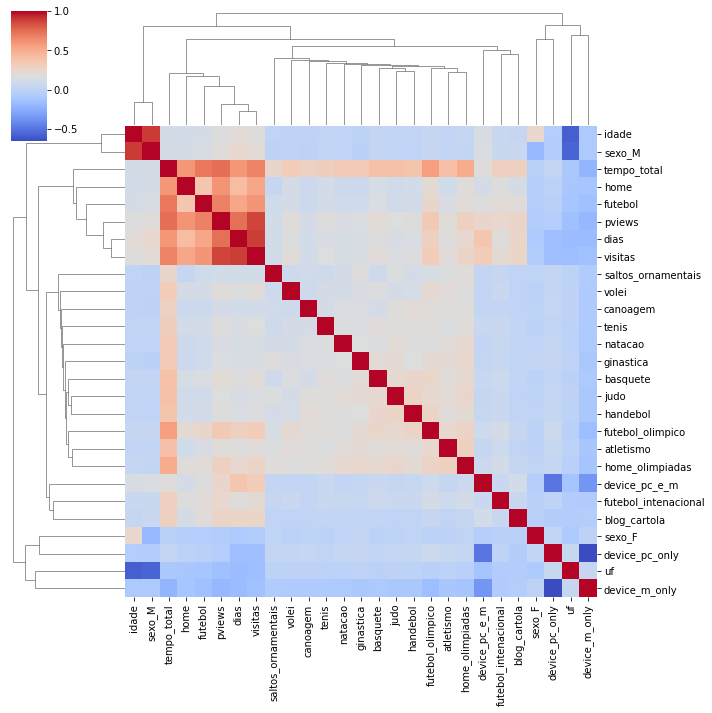

In [27]:
plt.figure(figsize=(16, 10))
sns.clustermap(df.corr(), cmap='coolwarm')
plt.show()

In [28]:
df.reset_index(inplace=True, drop=True)

I think we are ok with the preparation, so I will export to modeling next.

In [29]:
pickle.dump(df, open('data/df_model.pkl', 'wb'))